# Restricted Boltzmann Machines

### Energy-based model
Energy-based models associate a scalar energy to each configuration of the variables of interest. Low energy is more desirable. The probability distribution based on an energy function can be defined as follows
$$ \Pr(x) = \frac{\exp (-E(x))}{Z}\,,$$
where $Z = \sum_{x} \exp (-E(x))$ denotes the normalization factor or **partition function**. 

### Restricted Boltzmann Machine

Restricted Boltzmann Machine (RBM) has an efficient training algorithm. 
In order to increase the expressive power of the model, we do not observe the example $x$ fully, 
we also want to introduce some non-observed variables.  Consider an observed part $x$ and a hidden part $h$. We can then write:
$$\Pr(x) = \sum_h \frac{\exp (-E(x, h))}{Z} \,.$$

In RBM, the energy function is defined as
$$
E(x, h) = -a^\top x - b^\top h - x^\top W h \,.
$$

To make RBM as an energy-based model, the free energy function is computed as follows
$$
\begin{align}
F(x) &= -\log \sum_h \exp (-E(x, h)) \\
     &= -a^\top x - \sum_j \log (1 + \exp(W^{\top}_jx + b_j))\,.
\end{align}
$$

We have an tractable expression for the conditional probabilities
$$
\Pr (h|x) = \prod_i \Pr (h_i | x)
$$

In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid


from libs import show_and_save
from libs import train as train

from matplotlib import pyplot as plt

Make some configurations

In [2]:
batch_size = 64 # batch size
n_epochs = 10 # number of epochs
lr = 0.01 # learning rate
n_hid = 128 # number of neurons in the hidden layer
# n_vis = 784 # input size

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
# Load CIFAR-10 dataset with continuous values
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.ToTensor(),  # Convert images to tensor
    # transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] otherwise 0-1
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)




train_dataset = datasets.MNIST('./output', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ]))
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    # shuffle=True
)

print(len(train_loader.dataset))

Files already downloaded and verified
60000


In [4]:
X,y = next(iter(train_loader))
input_size = X.view(X.size(0), -1).size(1)
output_shape = X.size()[1:]
print(torch.min(X), torch.max(X), input_size, output_shape)


tensor(0.) tensor(1.) 784 torch.Size([1, 28, 28])


Create a RBM model

In [5]:

# create a Restricted Boltzmann Machine
# n_vis = 784 # input size
from rbm import RBM as RBM1
model1 = RBM1(n_vis=input_size , n_hid=n_hid, output_shape = output_shape, k=1)
from rbm_gpt import RBM as RBM2
model2 = RBM2(n_visible=input_size , n_hidden=n_hid,output_shape = output_shape, k=1)
model3 = RBM2(n_visible=input_size , n_hidden=n_hid,output_shape = output_shape, k=1,binary = False)

In [6]:

def torch_device():
    # gpu - best
    if torch.cuda.is_available():
        return torch.device('cuda:0')
    # apple mps gpu - good
    if torch.backends.mps.is_available():
        return torch.device("mps")
    # cpu - slow   
    return torch.device('cpu')
device = torch_device()
device = torch.device('cpu')
print(device)
# import os


cpu


Then train the model.

In [7]:

# model2 = train(model2, train_loader, epochs=n_epochs, lr=lr,device=device)#,
# model1 = train(model1, train_loader, epochs=n_epochs, lr=lr,device=device)#,
model3 = train(model3, train_loader, epochs=n_epochs, lr=lr,device=device)#,


Epoch 1, Loss: -6.589032835543537
Epoch 2, Loss: -0.0964868297454899
Epoch 3, Loss: 0.6954041666059352


KeyboardInterrupt: 

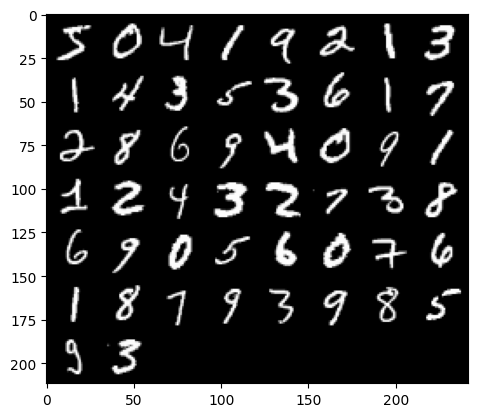

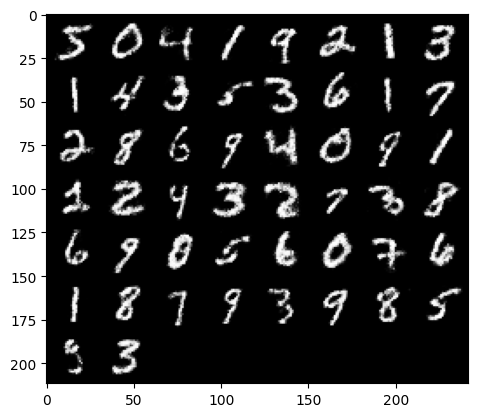

In [8]:
model = model3
images = next(iter(train_loader))[0]
images_reconstructed = model(images.to(device))
# show the real images
i=min(len(images),50)
# make_grid(images[:i])
show_and_save(make_grid(images[:i]), 'output/real')
# show the generated images
plt.figure()
show_and_save(make_grid(images_reconstructed.cpu()[:i]), 'output/fake')

In [ ]:
model = model2
images = next(iter(train_loader))[0]
images_reconstructed = model(images.to(device))
# show the real images
i=min(len(images),50)
# make_grid(images[:i])
show_and_save(make_grid(images[:i]), 'output/real')
# show the generated images
plt.figure()
show_and_save(make_grid(images_reconstructed.cpu()[:i]), 'output/fake')


RuntimeError: Placeholder storage has not been allocated on MPS device!

In [9]:
def generate_samples(model,n_samples=8, k=1, device='cpu'):
        model.to(device)
        samples = torch.randn(n_samples, model.n_hidden).to(device)  # Start with random hidden units
        
        for _ in range(k):
            _, visible = model.h_to_v(samples)
            _, samples = model.v_to_h(visible)
        
        return visible.cpu().detach().view(visible.size(0),*model.output_shape)
model = model3

generated = generate_samples(model,n_samples=8, k=1, device=device)

In [10]:
import numpy as np
g = generated.numpy()
np.unique(g[g>0])

array([6.51105417e-14, 1.40458626e-11, 1.06465954e-10, ...,
       9.99999762e-01, 9.99999881e-01, 1.00000000e+00], dtype=float32)

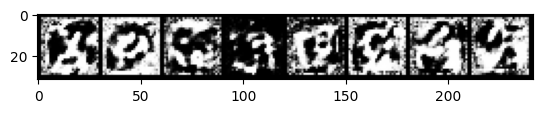

In [11]:
show_and_save(make_grid(generated), 'output/fake')


How one image is factorized through the hidden variables

In [ ]:
n_sample = 4
kth = 18
d = images[kth:kth+1].to(device)

V = torch.sigmoid(F.linear(d.view(1, -1), model.W, model.h))
v, o = torch.sort(V.view(-1))

fig, ax = plt.subplots(1, n_sample + 1, figsize=(3*(1 + n_sample),3))
ax[0].imshow(d.view(28, 28).cpu().numpy(), cmap='gray')
ax[0].set_title('Original image')

for k, i in enumerate(o[-n_sample:].cpu().numpy()):
    f = model.W[i].view(28, 28).data.cpu().numpy()
    ax[k + 1].imshow(f, cmap='gray')
    ax[k + 1].set_title('p=%.2f'% V[0][i].item())
    
plt.savefig('output/factor.png', dpi=200)

AttributeError: 'RBM' object has no attribute 'h'